## Some Practice with EEG Analysis in Python

### Overview

The purpose of this task is to give you a chance to get familiar with some techniques for analyzing EEG signals using Python. Our goal will be to predict whether or not a segment of data from an EEG corresponds to a seizure or not. Our analysis will consist of three main steps which are described in detail below.

## Step 1: Reading the data

The data for this project comes from the "Physionet" database collected by the Children's Hospital of Boston. The data consits of EEG recordings gathered from 10 children and young adults with medically resistant epilepsy. Each test subject has around 50 hours of recordings so there's a lot of data! A neurologist then went through all the data by hand and identified all the seizures. So each sample gets a value of `1` if it corresponds to a seizure and a `0` if not. The data was collected in a hospital setting and more subjects have data from at least 20 different electrodes. However, to be closer to the environment faced by developers of embedded systems we'll only look at two channels that are located near the temples. You can see some more detailed information about the data [here](https://physionet.org/content/chbmit/1.0.0/).

In the `../input/` folder you'll find a file `eeg_data_temples2.h5` which contains all the EEG recordings for the two channels we're interested in. Our first step will be to read this data into Python and convert it into a format our algorithm can work with. To do so, we'll use the `tables` library for Python which can read the `HDF5` file format which is used to store the EEG data.

## Side Note: Model Estimation and Feature Extraction

For this task we want to classify a short segment (commonly called a "window") of an EEG recording (4 seconds to be exact) as either being a during a seizure or not. To do so, we will use a logistic regression model. Very succinctly, a lostic regression is a statistical model which can be used predicts the value of a binary random variable (i.e. a random variable which takes on exactly two discrete values) known as the "outcome" or "dependent variable," given a set of observations of one or more "input" or "independent" variables. Very succinctly, suppose we have two input variables $x_1 \in \mathbb{R}$ and $x_2 \in \mathbb{R}$ (where $\mathbb{R}$ denotes the real numbers) and a discrete outcome $y \in \{0,1\}$. Then logistic regression first computes a linear function of those variables:

$$ z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 $$

and then "squashes" $z$ through a function (called the logistic-sigmoid) which converts $z$ into a probability. Putting both steps together we have:

$$ Pr(y = 1 | x_1, x_2) = \sigma(\beta_0 + \beta_1 x_1 + \beta_2 x_2) $$

where $\sigma(x) = \frac{1}{1+e^{-x}}$ is the logistic sigmoid. In general, we don't know $\beta_0, \beta_1, \beta_2$ and need to *estimate* them from some data. The $\beta$ are known as the model "parameters" and the process of estimating them is called "parameter estimation" (there's an entire ECE course that is just about parameter estimation). The algorithm to do this is somewhat complicated, but fortunately some other people have already implemented it for us. We just need to give their implementation a bunch of data corresponding to several observed values of $x_1$ and $x_2$ along with the correct value of $y$ for those data points. Their algorithm will give us back the "best" values of $\beta$. Then, if we observe values for $x_1$ and $x_2$ for which we *do not* know the correct value of $y$, we can plug those into the equation above along with the estimated values for the $\beta$ and compute the probabilty that these $x$ correspond to $y=1$. 

This is a very over-simplified description of logistic regression which has a number of interesting interpretations both statistically and geometrically which you're encouraged to read more about [here](https://en.wikipedia.org/wiki/Logistic_regression). In particular, I recommend reading the first two "examples" to get a bit more technical understanding of how the model works and how we define the "best" value of the $\beta$.

In our case the outcome variable will be "given the last four seconds of EEG data, is the person having a seizure?" So in this case our $x$ variables will be some variables which summarize the last four seconds of observed EEG data and our $y$ variable will be a $1$ if the person was having a seizure at any point in the last four seconds. The question of how to best summarize the signal so that a logistic regression gives good results has been the subject of considerable research and people have proposed a bunch of different values to extract from the seizure which may be useful. In this case we'll use a very simple model that uses the mean and variance of the signal in each window along with some features of the "frequency domain" which are well known to be useful by medical researchers. The term "frequency domain" refers to the representation of the signal obtained by computing its Fourier Transform. Recall that the [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) takes a signal which is measured as a function of time and decomposes it into a superposition of primitive waves oscilating at different frequencies. In many cases (including this one), the relative importance of these waves tells us useful things about the signal so it's very common to analyze signals in the frequency domain. If you don't know about Fourier Transforms, that's fine, but I recommend reading about them (or look up the 3Blue1Brown video about them) because they are very interesting.

So our first task will be to read the raw data collected on EEG and extract the various "features" from the raw signal.

In [1]:
import tables

import numpy as np
import pandas as pd

from scipy import signal
from scipy import integrate

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import os.path # to find and create directories

import matplotlib.pyplot as plt

In [2]:
# downsample training data to balance number of non-seizure and seizure data points (50/50 in this case)
def downSample(data_train, label_train):

    # since labels are bools, number of Trues is the number of seizures
    numSeizures = np.sum(label_train)
    
    # mask to select all non-seizure data for subject
    isFalse = (label_train == False)
    
    # select all non-seizure data for subject
    data_train_false = data_train[isFalse, :]

    # randomly sample numSeizures rows from non-seizure data
    sample = np.random.randint(np.size(data_train_false, 0), size = numSeizures)
    data_train_false = data_train[sample, :]
    
    if debug:
        print('Number of seizures {}'.format(numSeizures))
        print('Shape of false data after sample {}'.format(data_train_false.shape))
    
    # create same amount of zeroes (False) as number of seizures
    label_false = np.zeros(numSeizures, dtype='bool')

    if debug:
        print(label_false)
    
    # capture all data marked as seizure
    data_train_true = data_train[np.logical_not(isFalse), :]
    label_true = np.ones(numSeizures, dtype='bool')
                                  
    if debug:
        print(label_true)
    
    data_train_down = np.concatenate((data_train_false, data_train_true))
    label_train_down = np.concatenate((label_false, label_true))

    if debug:
        print('Shape of false data labels after sample {}'.format(label_train_down.shape))
        print(label_train_down)
    
    return data_train_down, label_train_down

In [3]:
# Let's examine the file. It contains several "nodes" each of which corresponds to one test subject
# Each node has several children which each correspond to (roughly) one hour of data.

# h5_file = tables.open_file("../input/eeg_data_temples2.h5")
# print(h5_file)

In [4]:
# This function computes the relative power in several frequency bands which
# are generally known to be medically relevant

def compute_band_relpower(X):
    band_relpower = []
    bands = [(0.5,4), (4,8), (8,13), (13,32), (32,60)]

    freqs, psd = signal.welch(X, fs=256.0, axis=0)
    fr_res = freqs[1] - freqs[0]

    where = lambda lb, ub: np.logical_and(freqs >= lb, freqs < ub)
    abs_power = np.concatenate(
            [integrate.simps(psd[where(lb, ub),:], dx=fr_res, axis=0
                ).reshape(1,-1) for lb, ub in bands]
        )
    total_power = integrate.simps(psd, dx=fr_res, axis=0).astype(np.float64)
    abs_power[:,total_power == 0] = 0
    total_power[total_power == 0] = -1
    band_relpower = (abs_power / total_power).ravel()    

    return band_relpower

In [5]:
# Now we'll read the data into a Python data structure and 
# extract features of the signal to be used in a statistical 
# algorithm for prediction
def readData():
    
    # try to load data from files
    try:
        print('Loading features.npy...')
        features = np.load('data/features.npy')

        print('Loading labels.npy...')
        labels = np.load('data/labels.npy')

        print('Loading subjects.npy...')
        subjects = np.load('data/subjects.npy')

        print('All data was succesfully loaded!\n')
        return features, labels, subjects

    # rebuild data if a file is missing
    except IOError:
        print('File was not found. Rebuilding data...')

    # open file
    h5_file = tables.open_file("../input/eeg_data_temples2.h5")

    directory = './data/'
    
    sampling_rate = 256     # how many observations (samples) are gathered every? second
    window_size_seconds = 4 # how many seconds of data do we want in a window?
    stride_seconds = 2      # how far should we advance the window at each step?

    window_size = window_size_seconds*sampling_rate
    stride = stride_seconds*sampling_rate

    features = []
    labels   = []
    subjects = []
    for node in h5_file.walk_nodes("/", "CArray"):
        node_data = node.read()
        subject_id = node._v_name.split("/")[0].split("_")[0]

        # The data for each node is an N x 3 numpy array (a matrix)
        # The first two columns are the EEG data and the third is an
        # indicator variable which is equal to 1 if the observation 
        # corresponds to a seizure

        X, y = node_data[:,:-1], node_data[:,-1]
        num_obs, num_channels = X.shape

        # Now we want to convert our data matrix (X) into a sequence
        # of overlapping windows

        for ix in range(window_size, num_obs, stride):
            X_w = X[ix-window_size:ix,:]

            # now let's extract the "features" mentioned above
            # TODO: compute the mean and variance of both channels of data
            # hint: use np.mean and np.var and look up the "axis" argument
            band_relpower = compute_band_relpower(X_w)
            #print(band_relpower)
            means = np.mean(X_w, axis = 0)
            variances = np.var(X_w, axis = 0)

            # TODO: concatenate all features into a single "feature vector"
            # hint: use np.concatenate
            feature_vector = np.concatenate((band_relpower, means, variances))
            features.append(feature_vector)

            labels.append(np.any(y[ix-window_size:ix]))
            subjects.append(subject_id)
        
    features = np.vstack(features)
    labels = np.array(labels)
    subjects = np.array(subjects)
    
    if not os.path.isdir(directory):
        os.mkdir(directory)

    # save arrays to respective files so we don't need to do this again
    np.save('data/features', features)
    np.save('data/labels', labels)
    np.save('data/subjects', subjects)
    
    # close file
    h5_file.close()

    return features, labels, subjects

## Step 2: Split Data into Train and Test Sets

We're now almost ready to pass our data (X) to the algorithm to estimate the model's parameters. But what if we got lucky and collected a bunch of data that's really easy to classify correctly? Then, our model will appear to be much better than it actually is. What we're really interested in is: how well does our model predict data on which it was not trained? A simple way to answer this question is to hold out a sub-sample of your data from training and then evaluate the accuracy of the model (how often it guesses the correct value) on this held out sample. This is known as "cross validation."

For medical applications where you often have multiple test subjects, the best way to perform cross validation is to exclude one subject from training and use that subject as the validation sample. The model is trained on everyone else and we use the test subject to estimate the model performance. So in this step, we want to split the data into a train and test set.

In [6]:
def getTrainAndTest(subID, data, label, subjects):

    is_test_set = (subjects == subID) # mask to select data for everyone, but subID

    data_train = data[np.logical_not(is_test_set),:] # get entire row of subject in data
    label_train = label[np.logical_not(is_test_set)] # get label of row
    data_train, label_train = downSample(data_train, label_train)

    if debug:
        print('getTrainAndTest - data {}, label {}'.format(data_train.shape, label_train.shape))

    # TODO: use the "is_test_set" variable to extract the rows of `X`
    # corresponding to the test subject.
    data_test = data[is_test_set, :]
    label_test = label[is_test_set]
    
    # As a final step, we'll resacle each of our features so that they
    # have a mean of zero and a standard deviation of one. Again, the 
    # reason why we do this is a bit technical, but in general ML models
    # don't like it when the features are on different scales.

    S = StandardScaler()
    data_train = S.fit_transform(data_train)
    data_test = S.transform(data_test)

    if debug:
        print('getTrainAndTest 2- data {}, label {}'.format(data_train.shape, label_train.shape))
    
    return data_train, label_train, data_test, label_test

## Step 3: Estimate Model Parameters

We're now finally ready to estimate the parameters of our model. Fortunately, this step is really easy. We just construct a `LogisticRegression` object and call its `fit` method. All the hard work was done by the creators of `scikit-learn` who implemented the algorithm for parameter estimation.

In [7]:
# TODO: construct a logistic regression object and call it's .fit()
# method with the training data
def trainModel(data_train, label_train, data_test, label_test, subID):

    directory = 'probs/'
    filename = '{}model'.format(subID)
    file_path = directory + filename

    if debug:
        print(label_train[0])
        print(label_train[-1])
        
    clf = LogisticRegression(random_state=0)
    clf.fit(data_train, label_train)

    # Now let's evaluate the performance of our model on the train and
    # test set. We can use the "predict" method of the model to obtain
    # predictions and compare these against the correct values
    # TODO: compute the accuracy of the model on the training and testing
    # datasets

    label_pred_train = clf.predict(data_train)
    train_accuracy = np.mean(np.equal(label_pred_train, label_train))

    label_pred_test = clf.predict(data_test)
    test_accuracy = np.mean(np.equal(label_pred_test, label_test))

    if not os.path.isdir(directory):
        os.mkdir(directory)

    # save best model so we can analyze probabilities of best fit model later
    probs = clf.predict_proba(data_test)
    np.save(file_path, probs)

    return label_pred_train, label_pred_test
    #print("Training accuracy was: {}".format(train_accuracy))
    #print("Test accuracy was: {}".format(test_accuracy))

### Debugging...

Wow! $99\%$ accuracy on the test set! Amazing! We've solved the problem of seizure detection! Or have we...

Let's compute the true negative and true positive rate for our classifier. I.e. how many examples that actually were `0` were correctly classified as `0` and how many that really were `1` were correctly classified as `1`.

In [8]:
# TODO: compute the "confusion matrix" for the model
# (hint: use the "confusion_matrix" function) and then use this
# to compute the true negative rate and true positive rate
def computeTrueNegAndPos(label_pred_test, label_test):
    
    cfn = confusion_matrix(label_pred_test, label_test)
    
    # number of correctly classified 0's divided by number of 0's in test
    true_negatives = cfn[0][0] / (len(label_test) - sum(label_test)) 
    
    # number of correctly classified 1's divided by number of 1's in test
    true_positives = cfn[1][1] / sum(label_test)
    
    return true_negatives, true_positives
    #print("True negative rate: {}".format(true_negatives))
    #print("True positive rate: {}".format(true_positives))

My true positive rate was $0\%$ - our model **never** correctly predicted that someone had a seizure - which is what we care about! So even though the accuracy is really high we actually have a terrible model. Why did this happen? Let's compute the fraction of training examples that are a `1`.

In [9]:
#print(np.mean(y_train))

Only about $0.1\%$ of the training data points are a `1`! Therefore, they contribute almost nothing to the model and it ignores them! Again the reality is more bit complicated but requires some technical details on how the training algorithm works. This is a common problem in ML called an "unbalanced training set." Which, in general, means your classifier sees way more of one class than the other(s). There are many methods to deal with unbalanced training sets. The simplest (but not the best) way is to downsample the overrepresented class to obtain a balanced training set with equal numbers of `0`'s and `1`'s.

In [10]:
# TODO: draw a random sample of the negative (0) training examples
# to ensure there are an equal number of 0's and 1's in the training
# data and estimate the model again.

# print("Training accuracy was: {}".format(train_accuracy))
# print("Test accuracy was: {}".format(test_accuracy))

# print("True negative rate: {}".format(true_negatives))
# print("True positive rate: {}".format(true_positives))

I got about $63\%$ - not great, but much better than before and better than guessing randomly so our model is doing something useful! Seizure detection is an extensively studied problem and there are dozens of papers written about different methods to do it. We used a very simple method and there are lots of tricks you can use to improve even a simple model like logistic regression. Some things you might consider trying:
* We could also consider *interactions* between the features and powers of a feature (e.g. a polynomial). For instance maybe $\mu_1\dot\mu_{2}$ is useful for the model.
* EEG signals are very noisy meaning they contain a lot of flucutations which are more or less random and don't tell us anything useful. There are lots of techniques in the literature on denoising. One common one is to compute the fourier transform of the signal and zero out high-frequency components of the signal (> 60Hz).
* Logistic regression is a fiarly simple model that requires manually extracting features from the signal. We could instead try a more complicated model which can "learn" the best features to extract. The most well known of this class of models are neural networks.

### Some More Analysis...
So far, we've only evaluated the performance of the model on a single test subject. We should repeat this process holding out each test subject to get a better sense of the models typical performance.

TODO: Repeat the above analysis holding out each subject. Write a function which takes the ID of the test subject, constructs the train and test sets (subsampling the training set), estimates models and returns the true negative and true positive rates. Create a table showing the true negative and true positive rate for each subject.

Finally: Pick the best model and plot the probability returned by the logistic regression model (on the test set) over time. The X-axis should represent time and the Y-axis should be the probability estimated by the model that the corresponding window is a seizure. Use different colors for seizure and non-seizure points and include a legend showing which color is which.

In [11]:
def testModelOnSubject(subID, features, labels, subjects):
    
    data_train, label_train, data_test, label_test = getTrainAndTest(subID, features, labels, subjects)
    label_pred_train, label_pred_test = trainModel(data_train, label_train, data_test, label_test, subID)
    
    # only computing for test set
    true_negatives, true_positives = computeTrueNegAndPos(label_pred_test, label_test)
    
    return true_negatives, true_positives

In [12]:
def testModel2OnSubject():
    
    
    
    return true_negative, true_positives

In [16]:
def plotData():
    
    directory = './probs/'
    filename = '{}model.npy'.format(best[0])
    file_path = directory + filename

    probs = np.load(file_path)

    print('Building plot of best model...')

    time = np.arange(1, len(probs) + 1)
    #val_neg = probs[ : , 0]
    val_pos = probs[ : , 1]

    # building plot
    plt.figure(figsize=(30, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax1.plot(time, val_pos, "s-")
    ax1.set_ylabel("Probability of Seizure")
    ax1.set_xlabel("Current 4-second Time Interval")
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_title('Probability of Seizure Over Time')
    
    print('Showing results for the best model:', best[0], '(leaving out non-seizures for now)')
    
    plt.tight_layout()
    plt.show()

### Things to Know

1) Data to train model is saved in the "src/data/" folder.

2) Probabilities for each subject is saved in the "src/probs/" folder.

3) I have not plotted seizure and non-seizure data against each other due to noise. This will get done once I confirm the correctness of the plot.

### TODO

1) Finish plot

In [17]:
debug = False

Loading features.npy...
Loading labels.npy...
Loading subjects.npy...
All data was succesfully loaded!

Running model...


/Users/darylnakamoto/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/darylnakamoto/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/darylnakamoto/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/darylnakamoto/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/darylnakamoto/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: 

Done! Results are shown below.

| Subject ID | True Negative Rate | True Positive Rate |
--------------------------------------------------------
| chb07      | 0.95805            | 0.66864            |
| chb04      | 0.93487            | 0.34343            |
| chb10      | 0.59010            | 0.78571            |
| chb05      | 0.46986            | 0.88581            |
| chb02      | 0.98773            | 0.23913            |
| chb01      | 0.98492            | 0.64103            |
| chb08      | 0.92206            | 0.47660            |
| chb09      | 0.61495            | 0.93836            |
| chb03      | 0.96371            | 0.33488            |
| chb06      | 0.45637            | 0.17708            |
--------------------------------------------------------

Building plot of best model...
Showing results for the best model: chb09 (leaving out non-seizures for now)


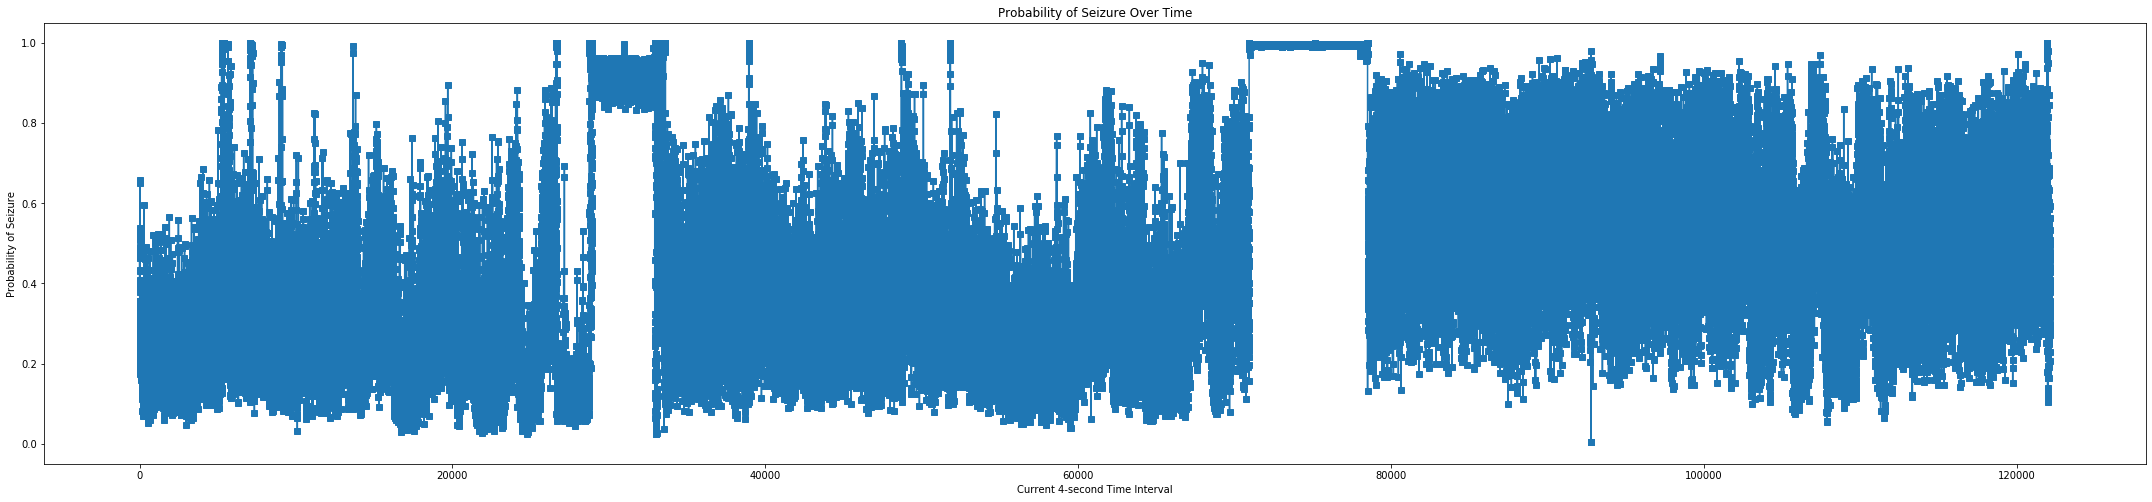

In [18]:
if __name__ == "__main__":

    subjectID = 'chb01'
    features, labels, subjects = readData()
    #uniqueSubs = ['chb01', 'chb02']
    uniqueSubs = set(subjects)
    tableData = []
    best = None
    
    print('Running model...')
    for sub in uniqueSubs:
        true_neg, true_pos = testModelOnSubject(sub, features, labels, subjects)

        if debug:
            print('main - sub {}, true_neg {}, true_pos {}'.format(sub, true_neg, true_pos))
            print([sub, true_neg, true_pos])

        currSubResults = [sub, true_neg, true_pos]

        if best == None or true_pos > best[2]:
            best = currSubResults

        tableData.append(currSubResults)
    
    print('Done! Results are shown below.\n')    
    print('| Subject ID | True Negative Rate | True Positive Rate |')
    print('--------------------------------------------------------')
    
    for data in tableData:
        print('|', data[0], " " * (9 - len(data[0])), 
              '|', '{:.5f}'.format(data[1]), " " * (10), 
              '|', '{:.5f}'.format(data[2]), " " * (10), '|')
    print('--------------------------------------------------------\n')

    plotData()